# Optimizing a TF (VGG16) model using SageMaker Neo

SageMaker NEO (https://aws.amazon.com/sagemaker/neo/) is a feature of SageMaker that you can use to optimize a trained model for best performance. It's an OpenSource project based on TVM and Treelite.

https://github.com/neo-ai

It combines a set of optmiziation techniques to reduce the model size, merging operators, etc.

In order to use SageMaker Neo you take a look at this page: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-troubleshooting.html. See the supported operators and then you can build your model following these orientations. After that you can use HyperParameter optimization and other strategies to train your model. So, you can then create a Compilation Job to optimize the trained model yet more.

The assests generated by SageMaker Neo is an intermediate model. It means that you don't need the original framework (used to create your model) anymore. Now you need to use DLR (https://github.com/neo-ai/neo-ai-dlr). A light runtime that will interpret the optimized model in the target device (CPU or GPU). Just install DLR into your device and do predictions!

##### In this exercise we'll create use the VGG16 implementation of part 1 and train a model. Later, we'll optimize that model with SageMaker NEO

## 1) Training/Optimizing the model
### (skip this whole session if you opted per a pretrained model)
### 1.1) Now, let's train our model with the whole Dataset 


In [1]:
import sagemaker
import time

from sagemaker.tensorflow import TensorFlow

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'caltech256'

role = sagemaker.get_execution_role()

In [2]:
local = False
source_dir = 'src'
model_dir = '/opt/ml/model'
train_instance_type = 'local_gpu' if local else 'ml.p3.2xlarge'
job_prefix='tf-caltech256-vgg16'

hyperparameters = {
    'epochs': 20, 
    'batch_size': 8,
    'num_classes': 257,
    'learning_rate': 0.00003
}
metric_definitions=[
   {'Name': 'train:accuracy', 'Regex': 'train_acc=(.*?);' },
   {'Name': 'validation:accuracy', 'Regex': 'val_acc=(.*?);' },
   {'Name': 'train:loss', 'Regex': 'train_loss=(.*?);' },
   {'Name': 'validation:loss', 'Regex': 'val_loss=(.*?);' }
]
estimator = TensorFlow(entry_point='caltech256_vgg16.py',
                       model_dir=model_dir,
                       #source_dir=source_dir,
                       train_instance_type=train_instance_type,
                       train_instance_count=1,
                       hyperparameters=hyperparameters,
                       role=role,
                       base_job_name=job_prefix,
                       framework_version='1.15.0',
                       metric_definitions=metric_definitions,
                       ## Uncomment the following lines for using Spot Instances
                       #train_use_spot_instances=True,
                       #train_max_run=100*60*60,
                       #train_max_wait=100*60*60,
                       py_version='py3',
                       script_mode=True)

In [3]:
if local:
    pwd=!pwd
    train_dir='{}/dataset/sample/train'.format(pwd[0])
    test_dir='{}/dataset/sample/test'.format(pwd[0])
    inputs = {'train': f'file://{train_dir}',
              'test': f'file://{test_dir}'}
else:
    inputs = {'train': 's3://%s/%s/train' % (bucket, prefix),
             'test': 's3://%s/%s/test' % (bucket, prefix)}
estimator.fit(inputs)
frozen_model = False

2020-02-25 16:02:16 Starting - Starting the training job...
2020-02-25 16:02:18 Starting - Launching requested ML instances.........
2020-02-25 16:03:52 Starting - Preparing the instances for training......
2020-02-25 16:04:57 Downloading - Downloading input data.....................
2020-02-25 16:08:38 Training - Downloading the training image...
2020-02-25 16:08:59 Training - Training image download completed. Training in progress.WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1467: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2020-02-25 16:09:04,950 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-02-25 16:09:05,505 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "train": "/opt/ml/input/data/train"
    },


Epoch No: 11
train_acc=0.4009; train_loss=0.3325;
val_acc=0.1581; val_loss=0.6302;
Elapsed time=2.03mins
Epoch No: 12
train_acc=0.4782; train_loss=0.2826;
val_acc=0.1615; val_loss=0.6843;
Elapsed time=2.04mins
Epoch No: 13
train_acc=0.5529; train_loss=0.2377;
val_acc=0.1724; val_loss=0.6669;
Elapsed time=2.03mins
Epoch No: 14
train_acc=0.6243; train_loss=0.1949;
val_acc=0.1667; val_loss=0.7668;
Elapsed time=2.03mins
Epoch No: 15
train_acc=0.6757; train_loss=0.1620;
val_acc=0.1636; val_loss=0.8498;
Elapsed time=2.04mins
Epoch No: 16
train_acc=0.7315; train_loss=0.1354;
val_acc=0.1670; val_loss=0.8212;
Elapsed time=2.04mins
Epoch No: 17
train_acc=0.7747; train_loss=0.1101;
val_acc=0.1633; val_loss=0.9693;
Elapsed time=2.03mins
Epoch No: 18
train_acc=0.8015; train_loss=0.0963;
val_acc=0.1517; val_loss=0.9838;
Elapsed time=2.04mins
Epoch No: 19
train_acc=0.8336; train_loss=0.0809;
val_acc=0.1629; val_loss=0.9243;
Elapsed time=2.05mins
Epoch No: 20
train_acc=0.8514; train_loss=0.0699;
val_a

### 1.2) Helper functions and global variables

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import cv2
import io
import glob
import numpy as np
import time

all_image_paths = list(glob.glob('256_ObjectCategories/*/*.jpg'))

def read_random_image():
    random.shuffle(all_image_paths)
    img_path = all_image_paths[0]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    return img

def prepare_image(img):
    img = img.astype(np.float32)
    img -= [123.68, 116.779, 103.939]
    return np.expand_dims( img, axis=0 )

### 1.3) Deploy the endpoint

In [ ]:
if frozen_model:
    model_data = estimator.model_data
    original_model_data = model_data.replace('model.tar.gz', 'model_original.tar.gz')
    !aws s3 cp $original_model_data $model_data
    frozen_model = False
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------

### 1.3.1) Test the endpoint

Elapsed time: 726ms 
Class id: 78 Confidence: 0.918268
CPU times: user 319 ms, sys: 19.8 ms, total: 339 ms
Wall time: 779 ms


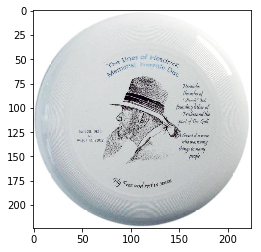

In [103]:
%%time
img = read_random_image()
payload = prepare_image( img )
start_time = time.time()
preds = predictor.predict( payload )
print( "Elapsed time: %dms " % int((time.time() - start_time) * 1000) )

idx = np.argmax(np.array(preds['predictions'][0]))
val = preds['predictions'][0][idx]

print("Class id: %d Confidence: %f" % (idx,val))
plt.imshow(img)

### 1.2) After finish training,deploying and testing the TF endpoint, we can now start a new Optimization Job with SageMaker NEO

SagemakerNeo Doesn't like the saved model for serving mode, so, we need to keep only the fronzen model into the .tar.gz

In [24]:
if not frozen_model:
    model_data = estimator.model_data
    original_model_data = model_data.replace('model.tar.gz', 'model_original.tar.gz')
    frozen_model_data = model_data.replace('model.tar.gz', 'model_frozen.tar.gz')

    print('Copy the original from S3')
    !aws s3 cp $model_data .
    print('Extract the frozen model and generate a new .tar.gz with only that file in it')
    !tar -xzvf model.tar.gz frozen_model.pb
    !tar -czvf model_frozen.tar.gz frozen_model.pb

    print('Upload the new .tar.gz with the fronzen model')
    !aws s3 cp model_frozen.tar.gz $frozen_model_data
    !aws s3 cp $model_data $original_model_data
    !aws s3 cp $frozen_model_data $model_data

    print('Clean the mess')
    !rm -f model.tar.gz model_frozen.tar.gz frozen_model.pb
    frozen_model = True

Copy the original from S3
download: s3://sagemaker-us-east-1-715445047862/tf-caltech256-vgg16-2020-02-25-16-02-16-020/output/model.tar.gz to ./model.tar.gz
Extract the frozen model and generate a new .tar.gz with only that file in it
frozen_model.pb
frozen_model.pb
Upload the new .tar.gz with the fronzen model
upload: ./model_frozen.tar.gz to s3://sagemaker-us-east-1-715445047862/tf-caltech256-vgg16-2020-02-25-16-02-16-020/output/model_frozen.tar.gz
copy: s3://sagemaker-us-east-1-715445047862/tf-caltech256-vgg16-2020-02-25-16-02-16-020/output/model.tar.gz to s3://sagemaker-us-east-1-715445047862/tf-caltech256-vgg16-2020-02-25-16-02-16-020/output/model_original.tar.gz
copy: s3://sagemaker-us-east-1-715445047862/tf-caltech256-vgg16-2020-02-25-16-02-16-020/output/model_frozen.tar.gz to s3://sagemaker-us-east-1-715445047862/tf-caltech256-vgg16-2020-02-25-16-02-16-020/output/model.tar.gz
Clean the mess


### Ok, now we're good to go and optimize our model
Just pay attention to the env var. It's required due to the Tensorflow Estimator doesn't pass this env to the deployed endpoint, what causes an error

In [34]:
target_device='ml_m4'  #'ml_m4'|'ml_m5'|'ml_c4'|'ml_c5'|'ml_p2'|'ml_p3'|'jetson_tx1'|'jetson_tx2'|'rasp3b'|'deeplens'

training_job_hyperparameters = estimator.hyperparameters()
optimized_estimator = estimator.compile_model(
    target_instance_family = target_device, 
    input_shape = '{"data":[1,224,224,3]}',
    output_path="s3://%s/%s/optimized" % (bucket, prefix),
    framework='tensorflow',
    framework_version='1.15.0',
    compile_max_run=500,
    env={
        'SAGEMAKER_SUBMIT_DIRECTORY': training_job_hyperparameters['sagemaker_submit_directory'].replace('"', '')
    } # besides that, sourcedir.tar.gz must have only ONE .py file AND, implement neo_postprocess/neo_preprocess
)

?........................................................!

### Now we can deploy a real-time endpoint with the optmized model

In [49]:
predictor_optimized = optimized_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
predictor_optimized.content_type='application/vnd+python.numpy+binary'

-------------------!

Elapsed time: 671ms 
Class id: 78 Confidence: 0.009687
CPU times: user 26.8 ms, sys: 0 ns, total: 26.8 ms
Wall time: 688 ms


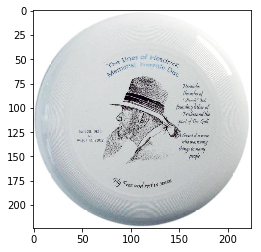

In [105]:
%%time
img = img if img is not None else read_random_image()

payload = io.BytesIO()
np.save(payload, img.astype(np.float32))
payload.seek(0)

start_time = time.time()
preds = predictor_optimized.predict(payload)
print( "Elapsed time: %dms " % int((time.time() - start_time) * 1000) )

idx = np.argmax(preds)
val = preds[idx]

print("Class id: %d Confidence: %f" % (idx,val))
plt.imshow(img)

## 2) Use a pre-trained model instead (in construction)
### (skip this session if you already executed session 1)
If you skiped Session 1 you probably want a pre-trained model.

It makes sense if you don't have access to a P3 instance or don't want to spend ~1h/P3 training a yet another VGG16 vs caltech256

In [22]:
!aws s3 cp s3://spock.cloud/ai-workshop/tf_vgg16_caltech256/model.tar.gz .
!tar -xzvf model.tar.gz -C model/

download: s3://spock.cloud/ai-workshop/tf_vgg16_caltech256/model.tar.gz to ./model.tar.gz
0001/
0001/frozen_model.pb


In [31]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [32]:
base_prefix = 'caltech256'
prefix=base_prefix + '/model'
inputs = sagemaker_session.upload_data(path='/tmp/model_2.tar.gz', bucket=bucket, key_prefix=prefix)

## 4) Then, let's do some predictions and compute the times

In [131]:
import numpy as np
import time

max_tries = 10
elapsed_time = np.zeros((2, max_tries), dtype=np.float32)
for i in range(max_tries):
    img = read_random_image()
    payload = prepare_image(img)
    payload_optimized = io.BytesIO()
    np.save(payload_optimized, img.astype(np.float32))
    payload_optimized.seek(0)
    input_data = {'Placeholder': payload}    
    
    print("Iteration %d/%d" % (i,max_tries))
    start_time = time.time()
    predictor.predict(payload)
    #c.predict_fn(payload, tfl_model)
    elapsed_time[0][i] = time.time() - start_time
    
    start_time = time.time()
    predictor_optimized.predict(payload_optimized)
    #neo_model.run(input_data)
    elapsed_time[1][i] = time.time() - start_time
    
avg_tf,avg_neo = np.average(elapsed_time[0]),np.average(elapsed_time[1])
print("Optimization gain: %0.2f%%" % (avg_neo/avg_tf * 100) )

Iteration 0/10
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Optimization gain: 62.89%


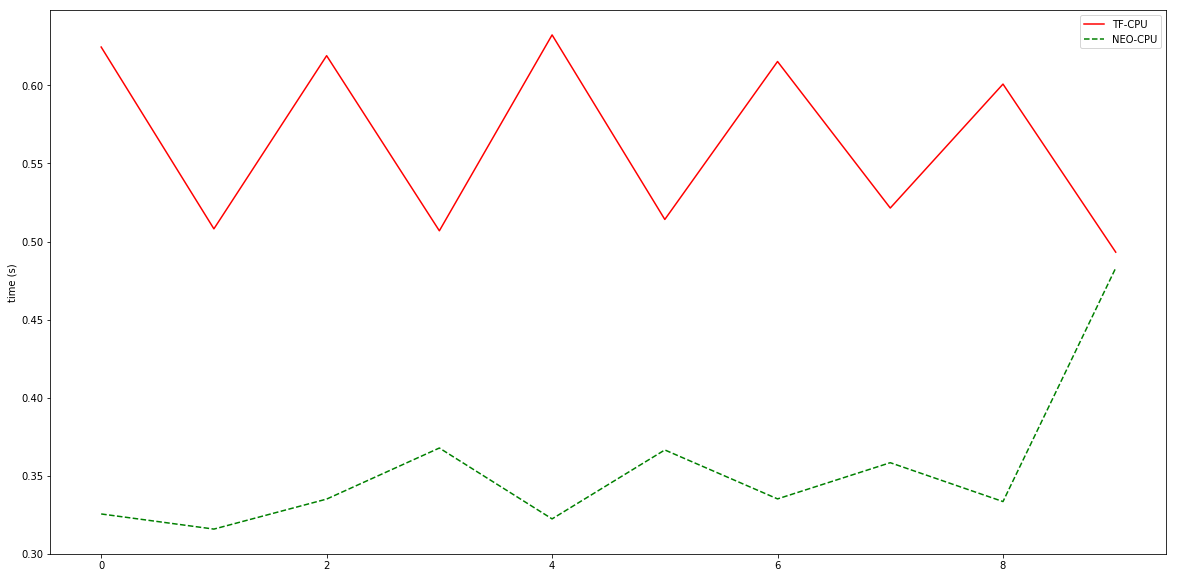

In [132]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1)
plt.ylabel('time (s)')
ax.set_prop_cycle(color=['red', 'green'])
ax.plot(elapsed_time[0], '-',label='TF-CPU')
ax.plot(elapsed_time[1], '--', label='NEO-CPU')
ax.legend()